In [63]:
![ -d sample_data ] && rm -rf sample_data
!pip install yfinance --quiet

In [64]:
import codecs
import math
import copy
import json
import os
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import yfinance as yf

In [65]:
def fetch_stock_data(ticker, period):
    data = yf.download(
        tickers=ticker, period=period, interval="1d", progress=False, rounding=True
    )
    data = data.dropna()
    data = data.reset_index()
    data["Date"] = pd.to_datetime(data["Date"]).dt.date
    return data


def simple_line_graph(df):
    plt.figure(figsize=(18, 9))
    plt.plot(range(df.shape[0]), (df["Low"] + df["High"]) / 2.0)
    plt.xticks(range(0, df.shape[0], 500), df["Date"].loc[::500], rotation=45)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Mid Price", fontsize=18)
    plt.show()


def data_visualization(data, name):
    fig = go.Figure()
    fig.add_trace(
        go.Candlestick(
            x=data["Date"],
            open=data["Open"],
            high=data["High"],
            low=data["Low"],
            close=data["Close"],
            name="market data",
        )
    )
    fig.update_layout(title=name, yaxis_title="Stock Price (INR)")
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=15, label="15m", step="minute", stepmode="backward"),
                    dict(count=45, label="45m", step="minute", stepmode="backward"),
                    dict(count=1, label="6mo", step="month", stepmode="backward"),
                    dict(count=6, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
    )
    fig.show()

In [66]:
STOCKS = ["BRITANNIA.BO", "RELIANCE.BO", "SBIN.BO", "ITC.BO"]

stock_of_interest_index = 1
stock_ticker = STOCKS[stock_of_interest_index]
stock_name, _ = stock_ticker.split(".")
stock_name = stock_name.lower()


def fetch_load_history_price(force_refetch=False):
    raw_df_file = ("data/" + stock_ticker.replace(".", "_") + ".csv").lower()
    if not force_refetch and os.path.exists(raw_df_file):
        return pd.read_csv(raw_df_file)

    df = fetch_stock_data(stock_ticker, "50y")
    df.to_csv(raw_df_file)
    return df


dir_data = "data"
dir_neural_compute = "neural_compute"
dir_export = "export"
dir_learning_images = "learning_images"
dir_trade = dir_export + "/trade"

if not os.path.exists(dir_data):
    os.makedirs(dir_data)

if not os.path.exists(dir_neural_compute):
    os.makedirs(dir_neural_compute)

if not os.path.exists(dir_export):
    os.makedirs(dir_export)

if not os.path.exists(dir_trade):
    os.makedirs(dir_trade)

if not os.path.exists(dir_learning_images):
    os.makedirs(dir_learning_images)

if not os.path.exists(dir_learning_images + "/" + stock_name):
    os.makedirs(dir_learning_images + "/" + stock_name)


df = fetch_load_history_price(False)
#simple_line_graph(df)
data_visualization(df, "{} Share Price".format(stock_name.capitalize()))

In [67]:
all_time_high_prices = max(df.loc[:, "High"])
no_of_lable_on_yaxis = 20
hop_size_on_yaxis = int(all_time_high_prices / no_of_lable_on_yaxis)
max_range_on_yaxis = int(all_time_high_prices + 2 * hop_size_on_yaxis)

total_no_of_data_point = df.shape[0]
no_of_testing_data_point = 500  # we will test model on 500 data points
train_start_index = 0
train_end_index = total_no_of_data_point - no_of_testing_data_point
test_start_index = train_end_index + 1
test_end_index = total_no_of_data_point

smoothing_window_size = 700


# calculate the mid prices from the highest and lowest
high_prices = df.loc[:, "High"].to_numpy()
low_prices = df.loc[:, "Low"].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0
# train_data = mid_prices[:train_end_index]
# test_data = mid_prices[train_end_index:]

# Scaling the data to be between 0 and 1
# Normalize both test and train data with respect to training data as we are not supposed to have access to test data
scaler = MinMaxScaler()
# train_data = train_data.reshape(-1,1)
# test_data = test_data.reshape(-1,1)

mid_prices = mid_prices.reshape(-1, 1)
scaler.fit(mid_prices)
mid_prices = scaler.transform(mid_prices)
train_data = mid_prices[:train_end_index]
test_data = mid_prices[train_end_index:]
train_data = train_data.reshape(-1)
test_data = test_data.reshape(-1)
mid_prices = mid_prices.reshape(-1)
# print(scaler.inverse_transform(mid_prices).reshape(-1))
# print(mid_prices)
"""
# Normalize training data to smooth data
#smoothing_window_size = 700
for di in range(0, train_end_index, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data
if di+smoothing_window_size < train_end_index:
    scaler.fit(train_data[di+smoothing_window_size:,:])
    train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
#train_data = train_data.reshape(-1)

# Normalize test data
#test_data = scaler.transform(test_data).reshape(-1)
"""
# perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(train_end_index):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

In [68]:
class DataGeneratorSeq(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length // self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size), dtype=np.float32)
        batch_labels = np.zeros((self._batch_size), dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b] + 1 >= self._prices_length:
                # self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0, 5)]

            self._cursor[b] = (self._cursor[b] + 1) % self._prices_length

        return batch_data, batch_labels

    def unroll_batches(self):

        unroll_data, unroll_labels = [], []
        init_data, init_label = None, None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(
                0, min((b + 1) * self._segments, self._prices_length - 1)
            )


dg = DataGeneratorSeq(train_data, 5, 5)
u_data, u_labels = dg.unroll_batches()
for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
    # print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    # print('\tInputs: ',dat )
    # print('\n\tOutput:',lbl)

In [ ]:
D = 1  # Dimensionality of the data. Since data is 1-D this would be 1
num_unrollings = 25  # Number of time steps we look into the future.
batch_size = 250  # Number of samples in a batch
num_nodes = [
    200,
    200,
    150,
]  # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes)  # number of layers
dropout = 0.2  # dropout amount
tf.compat.v1.reset_default_graph()  # This is important in case you run this multiple times

# Input data.
# Why the FUCK tf.placeholder() is not compatible with eager execution? Why Google Why??? :(
tf.compat.v1.disable_eager_execution()

train_inputs, train_outputs = [], []

# Unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(
        tf.compat.v1.placeholder(
            tf.float32, shape=[batch_size, D], name="train_inputs_%d" % ui
        )
    )
    train_outputs.append(
        tf.compat.v1.placeholder(
            tf.float32, shape=[batch_size, 1], name="train_outputs_%d" % ui
        )
    )

lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(
        num_units=num_nodes[li],
        state_is_tuple=True,
        initializer=tf.compat.v1.keras.initializers.VarianceScaling(
            scale=1.0, mode="fan_avg", distribution="uniform"
        ),
    )
    for li in range(n_layers)
]

drop_lstm_cells = [
    tf.compat.v1.nn.rnn_cell.DropoutWrapper(
        lstm,
        input_keep_prob=1.0,
        output_keep_prob=1.0 - dropout,
        state_keep_prob=1.0 - dropout,
    )
    for lstm in lstm_cells
]
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

w = tf.compat.v1.get_variable(
    "w",
    shape=[num_nodes[-1], 1],
    initializer=tf.compat.v1.keras.initializers.VarianceScaling(
        scale=1.0, mode="fan_avg", distribution="uniform"
    ),
)
b = tf.compat.v1.get_variable("b", initializer=tf.random.uniform([1], -0.1, 0.1))

In [ ]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [], []
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(
        tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li], h[li])
    )  # upgraded to tenserflow 2.0

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format bcz https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t, 0) for t in train_inputs], axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(
    drop_multi_cell,
    all_inputs,
    initial_state=tuple(initial_state),
    time_major=True,
    dtype=tf.float32,
)

all_lstm_outputs = tf.reshape(
    all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]]
)
all_outputs = tf.compat.v1.nn.xw_plus_b(all_lstm_outputs, w, b)
split_outputs = tf.split(all_outputs, num_unrollings, axis=0)


# When calculating the loss we need to be careful about the exact form, because we calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print("Defining training Loss")
loss = 0.0
with tf.control_dependencies(
    [tf.compat.v1.assign(c[li], state[li][0]) for li in range(n_layers)]
    + [tf.compat.v1.assign(h[li], state[li][1]) for li in range(n_layers)]
):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(
            input_tensor=0.5 * (split_outputs[ui] - train_outputs[ui]) ** 2
        )

print("Learning rate decay operations")
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step, global_step + 1)
tf_learning_rate = tf.compat.v1.placeholder(shape=None, dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None, dtype=tf.float32)

learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(
        tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True
    ),
    tf_min_learning_rate,
)

# Optimizer.
print("TF Optimization operations")
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients, v))
print("\tAll done")


print("Defining prediction related TF functions")

sample_inputs = tf.compat.v1.placeholder(tf.float32, shape=[1, D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [], [], []
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(
        tf.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li], sample_h[li])
    )  # up to 2.0

reset_sample_states = tf.group(
    *[
        tf.compat.v1.assign(sample_c[li], tf.zeros([1, num_nodes[li]]))
        for li in range(n_layers)
    ],
    *[
        tf.compat.v1.assign(sample_h[li], tf.zeros([1, num_nodes[li]]))
        for li in range(n_layers)
    ]
)

sample_outputs, sample_state = tf.compat.v1.nn.dynamic_rnn(
    multi_cell,
    tf.expand_dims(sample_inputs, 0),
    initial_state=tuple(initial_sample_state),
    time_major=True,
    dtype=tf.float32,
)

with tf.control_dependencies(
    [tf.compat.v1.assign(sample_c[li], sample_state[li][0]) for li in range(n_layers)]
    + [tf.compat.v1.assign(sample_h[li], sample_state[li][1]) for li in range(n_layers)]
):
    sample_prediction = tf.compat.v1.nn.xw_plus_b(
        tf.reshape(sample_outputs, [1, -1]), w, b
    )

print("\tAll done")

In [71]:
def train_and_predict(
    epochs, valid_summary, n_predict_once, verbose=True, force_recompute=True
):
    # if json serialized compute exist for same stock don't recompute unless foce_recompute is enbled
    file_path = (
        dir_neural_compute
        + "/"
        + stock_ticker.replace(".", "_").lower()
        + "_"
        + ("_".join([str(epochs), str(valid_summary), str(n_predict_once)])).lower()
        + ".json"
    )
    if not force_recompute and os.path.exists(file_path):
        train_and_predict = codecs.open(file_path, "r", encoding="utf-8").read()
        result_train_and_predictions = json.loads(train_and_predict)
        for key, value in result_train_and_predictions.items():
            if key == "x_axis_seq":
                continue
            value["predictions_over_time"] = [
                np.array(npa) for npa in value["predictions_over_time"]
            ]
            print(key)
            print(value["MSE"])
            print()
        return result_train_and_predictions

    train_seq_length = train_data.size  # Full length of the training data

    train_mse_ot = []  # Accumulate Train losses
    test_mse_ot = []  # Accumulate Test loss
    predictions_over_time = []  # Accumulate predictions

    session = tf.compat.v1.InteractiveSession()
    tf.compat.v1.global_variables_initializer().run()

    # Used for decaying learning rate
    loss_nondecrease_count = 0
    loss_nondecrease_threshold = 2  # If the test error hasn't increased in this many steps, decrease learning rate
    if verbose:
        print("Initialized")

    average_loss = 0
    # Define data generator
    data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)
    x_axis_seq = []
    result_train_and_predictions = {}
    # Points you start your test predictions from
    # test_points_seq = np.arange(train_end_index,(test_end_index-(test_end_index%25))+25,25).tolist()
    test_points_seq = np.arange(
        train_end_index,
        (test_end_index - (test_end_index % n_predict_once))
        + n_predict_once,  # add n_predict_once to predict 25 days in real future for which we don't have data yet
        n_predict_once,
    ).tolist()

    for ep in range(epochs):
        log_data = {}
        ######################### Training ####################################
        for step in range(train_seq_length // batch_size):
            u_data, u_labels = data_gen.unroll_batches()
            feed_dict = {}
            for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
                feed_dict[train_inputs[ui]] = dat.reshape(-1, 1)
                feed_dict[train_outputs[ui]] = lbl.reshape(-1, 1)
            feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate: 0.000001})
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l

        ############################# Validation ############################
        if (ep + 1) % valid_summary == 0:
            average_loss = average_loss / (
                valid_summary * (train_seq_length // batch_size)
            )
            # The average loss
            if (ep + 1) % valid_summary == 0:
                log_data["Average loss"] = average_loss
                if verbose:
                    print("Average loss at step %d: %f" % (ep + 1, average_loss))

            train_mse_ot.append(average_loss)
            average_loss = 0  # reset loss
            predictions_seq = []
            mse_test_loss_seq = []

            ##################### Update State and Make Predicitons ########################
            for w_i in test_points_seq:
                mse_test_loss = 0.0
                our_predictions = []

                if (ep + 1) - valid_summary == 0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis = []

                # Feed in the recent past behavior of stock prices
                # to make predictions from that point onwards
                for tr_i in range(w_i - num_unrollings + 1, w_i - 1):
                    current_price = all_mid_data[tr_i]
                    feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)
                    _ = session.run(sample_prediction, feed_dict=feed_dict)

                feed_dict = {}
                current_price = all_mid_data[w_i - 1]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)

                # Make predictions for this many steps
                # Each prediction uses previous prediciton as it's current input
                for pred_i in range(n_predict_once):
                    pred = session.run(sample_prediction, feed_dict=feed_dict)
                    our_predictions.append(np.asscalar(pred))
                    feed_dict[sample_inputs] = np.asarray(pred).reshape(-1, 1)
                    if (ep + 1) - valid_summary == 0:
                        # Only calculate x_axis values in the first validation epoch
                        x_axis.append(w_i + pred_i)
                    if w_i < test_end_index:
                        mse_test_loss += 0.5 * (pred - all_mid_data[w_i + pred_i]) ** 2

                session.run(reset_sample_states)
                predictions_seq.append(np.array(our_predictions))
                mse_test_loss /= n_predict_once
                mse_test_loss_seq.append(mse_test_loss)

                if (ep + 1) - valid_summary == 0:
                    x_axis_seq.append(x_axis)

            current_test_mse = np.mean(mse_test_loss_seq)
            # Learning rate decay logic
            if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):
                loss_nondecrease_count += 1
            else:
                loss_nondecrease_count = 0

            if loss_nondecrease_count > loss_nondecrease_threshold:
                session.run(inc_gstep)
                loss_nondecrease_count = 0
                if verbose:
                    print("\tDecreasing learning rate by 0.5")

            test_mse_ot.append(current_test_mse)
            predictions_over_time.append(predictions_seq)

            log_data["MSE"] = np.mean(mse_test_loss_seq)[0][0]
            log_data["predictions_over_time"] = predictions_seq
            if verbose:
                print("\tTest MSE: %.5f" % np.mean(mse_test_loss_seq))
                print("\tFinished Predictions")
        result_train_and_predictions[str(ep + 1)] = log_data

    result_train_and_predictions["x_axis_seq"] = x_axis_seq
    new = copy.deepcopy(result_train_and_predictions)
    for key, value in new.items():
        if key == "x_axis_seq":
            continue
        value["Average loss"] = value["Average loss"].tolist()
        value["MSE"] = value["MSE"].tolist()
        value["predictions_over_time"] = [
            npa.tolist() for npa in value["predictions_over_time"]
        ]
    json.dump(
        new,
        codecs.open(file_path, "w", encoding="utf-8"),
        separators=(",", ":"),
        indent=4,
    )
    session.close()
    return result_train_and_predictions


epochs = 30
valid_summary = 1  # Interval we make test predictions
n_predict_once = 25  # Number of steps we continously predict for
result_train_and_predictions = train_and_predict(
    epochs, valid_summary, n_predict_once, True, False
)
# predictions_over_time = result_train_and_predictions["predictions_over_time"]

# now define the structure of the result_for_train_and_predict network

1
0.03201581910252571

2
0.009657247923314571

3
0.006498540285974741

4
0.00409223698079586

5
0.003664453513920307

6
0.00235444656573236

7
0.0023360024206340313

8
0.001585877500474453

9
0.0015430074417963624

10
0.0016932548023760319

11
0.004031967371702194

12
0.0018219826743006706

13
0.00447808438912034

14
0.003627544967457652

15
0.005119585432112217

16
0.0032540124375373125

17
0.004824918694794178

18
0.004880940075963736

19
0.0045061614364385605

20
0.004485941957682371

21
0.004619790706783533

22
0.006415934767574072

23
0.005626127123832703

24
0.005136702209711075

25
0.005980128888040781

26
0.005841140169650316

27
0.006058947648853064

28
0.006103732623159885

29
0.0060710120014846325

30
0.005693952087312937



                                                ----------------- MSE and AVG loss evolution ----------------

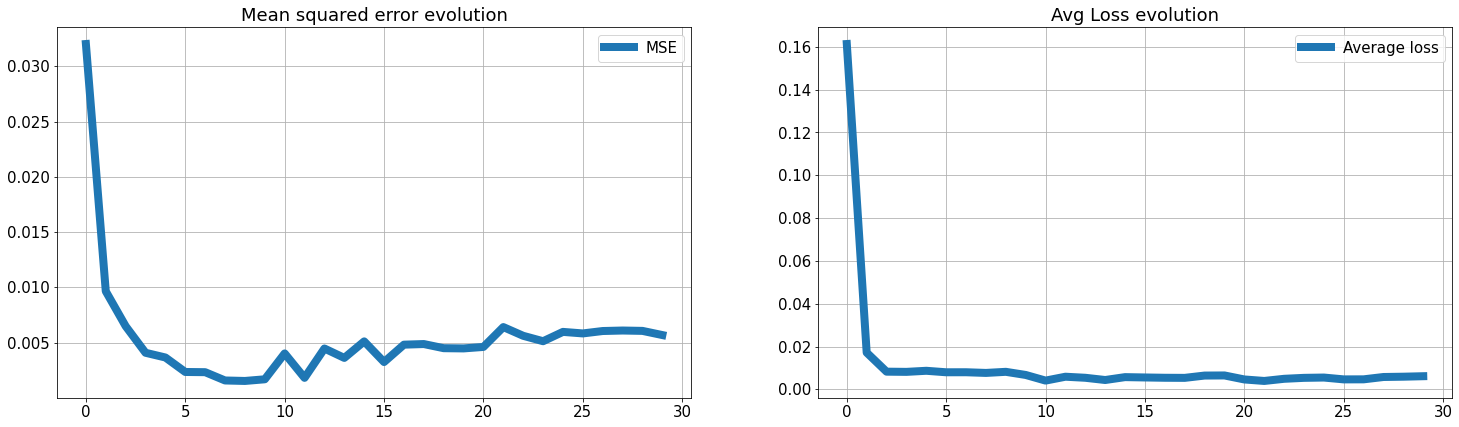

In [72]:
# MSE and avg loss evolution
def error_estimation():
    plt.figure(figsize=(25, 15))
    plt.rcParams.update({"font.size": 15})
    plt.rcParams.update({"lines.linewidth": 8})
    
    plt.subplot(2, 2, 1)
    plt.plot(
        [
            value["MSE"]
            for key, value in result_train_and_predictions.items()
            if key != "x_axis_seq"
        ],
        label="MSE",
    )
    plt.legend()
    plt.grid()
    plt.title("Mean squared error evolution")

    plt.subplot(2, 2, 2)
    plt.plot(
        [
            value["Average loss"]
            for key, value in result_train_and_predictions.items()
            if key != "x_axis_seq"
        ],
        label="Average loss",
    )
    plt.title("Avg Loss evolution")
    plt.legend()
    plt.grid()

error_estimation()

In [ ]:
# Structure of Nural Compute Dict
"""
result_train_and_predict = {
    "1" : {
        "Average loss" : 0.134,
        "MSE" : 0.00145,
        "predictions_over_time" : [
            array([0.64819837, 0.66429901, 0.67764157, 0.68811363, 0.69583184,
            0.7010473 , 0.70407873, 0.70526296, 0.7049275 , 0.70337147,
            0.70085764, 0.69761014, 0.69381475, 0.68962288, 0.6851542 ,
            0.68050301, 0.67574018, 0.6709193 , 0.66607994, 0.66124904,
            0.6564458 , 0.65168244, 0.64696628, 0.64230096, 0.6376884 ]),

            array([0.64819837, 0.66429901, 0.67764157, 0.68811363, 0.69583184,
            0.7010473 , 0.70407873, 0.70526296, 0.7049275 , 0.70337147,
            0.70085764, 0.69761014, 0.69381475, 0.68962288, 0.6851542 ,
            0.68050301, 0.67574018, 0.6709193 , 0.66607994, 0.66124904,
            0.6564458 , 0.65168244, 0.64696628, 0.64230096, 0.6376884 ]),
        ],
    },
    ...
    "x_axis_seq" : [[6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499], [6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524], [6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549], [6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6574], [6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599], [6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624], [6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649], [6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674], [6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699], [6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724], [6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749], [6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774], [6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799], [6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824], [6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849], [6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874], [6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899], [6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924], [6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949], [6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974], [6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999]]

}
"""

In [74]:
# util functions for plot and data re-scaling
def index_to_date_map(index):
    if index >= total_no_of_data_point:
        return datetime.strptime(
            str(df.at[total_no_of_data_point - 1, "Date"]), "%Y-%m-%d"
        ) + timedelta(days=index - total_no_of_data_point + 1)
    return datetime.strptime(str(df.at[index, "Date"]), "%Y-%m-%d")


def get_unscaled_data(scaled_data):
    a_list = scaler.inverse_transform(scaled_data.reshape(-1, 1)).reshape(-1)
    return [round(num, 3) for num in a_list]


# Best epoch no
def get_best_epoch():
    mse = []
    for key, value in result_train_and_predictions.items():
        if key == "x_axis_seq":
            continue
        mse.append(value["MSE"])
    best_mse = min(mse)

    best_epoch = "1"
    for key, value in result_train_and_predictions.items():
        if key == "x_axis_seq":
            continue
        if value["MSE"] == best_mse:
            return key

                                                ----------------- Show Best Prediction ----------------

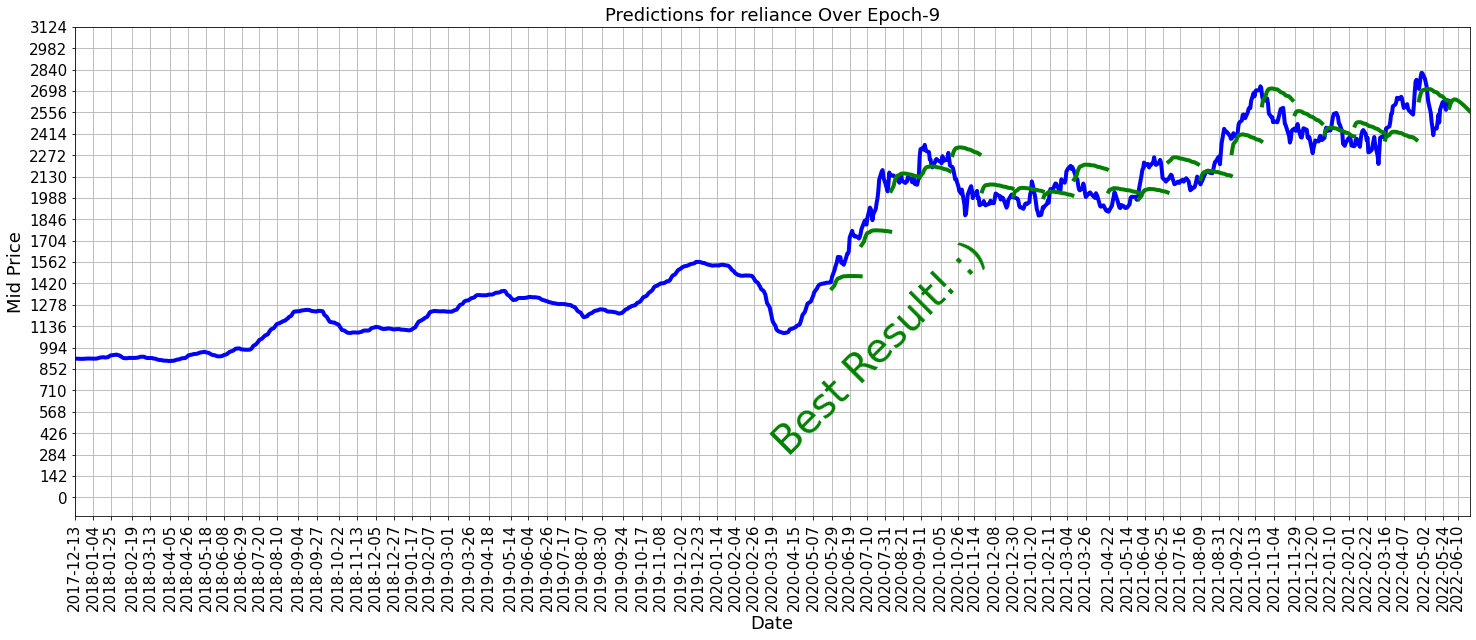

In [75]:
# Show Best Prediction
def show_graph(epoche_no, color, comment):
    plt.figure(figsize=(25, 9))
    plt.rcParams.update({"font.size": 15})
    plt.rcParams.update({"lines.linewidth": 4})

    best_prediction_epoch = epoche_no
    # Predicting the best test prediction we got
    # plt.plot(range(df.shape[0]),all_mid_data,color='b')
    plt.plot(
        [index_to_date_map(i) for i in range(df.shape[0])],
        get_unscaled_data(all_mid_data),
        color="b",
    )
    plt.text(
        index_to_date_map(train_end_index - 50),
        2 * hop_size_on_yaxis,
        comment,
        fontsize=40,
        color=color,
        rotation=45,
    )
    for xval, yval in zip(
        result_train_and_predictions["x_axis_seq"],
        result_train_and_predictions[str(best_prediction_epoch)][
            "predictions_over_time"
        ],
    ):
        plt.plot(
            [index_to_date_map(i) for i in xval], get_unscaled_data(yval), color=color
        )

    plt.title(
        "Predictions for {} Over Epoch-{}".format(stock_name, best_prediction_epoch),
        fontsize=18,
    )
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Mid Price", fontsize=18)
    plt.yticks(
        [i for i in range(0, max_range_on_yaxis, hop_size_on_yaxis)],
        [i for i in range(0, max_range_on_yaxis, hop_size_on_yaxis)],
    )
    plt.xticks(
        [index_to_date_map(i) for i in range(train_end_index - 600, xval[-1], 15)],
        [
            index_to_date_map(i).date()
            for i in range(train_end_index - 600, xval[-1], 15)
        ],
        rotation=90,
    )
    # plt.xticks([index_to_date_map(i) for i in range(train_end_index-500,test_end_index,10)], [index_to_date_map(i).date() for i in range(train_end_index-500,test_end_index,10)], rotation=90)
    # plt.xlim(index_to_date_map(train_end_index-10),index_to_date_map(test_end_index-1))
    plt.xlim(index_to_date_map(train_end_index - 600), index_to_date_map(xval[-1]))
    plt.grid()
    plt.show()


mse = []
for key, value in result_train_and_predictions.items():
    if key == "x_axis_seq":
        continue
    mse.append(value["MSE"])
mse = sorted(mse)
mse = mse[:10]

for key, value in result_train_and_predictions.items():
    if key == "x_axis_seq":
        continue
    if value["MSE"] == mse[0]:
        plt.close()
        color = "g"
        comment = "Best Result! :)"
        show_graph(int(key), color, comment)

                                        ------------ Zoom In future Predictions ------------

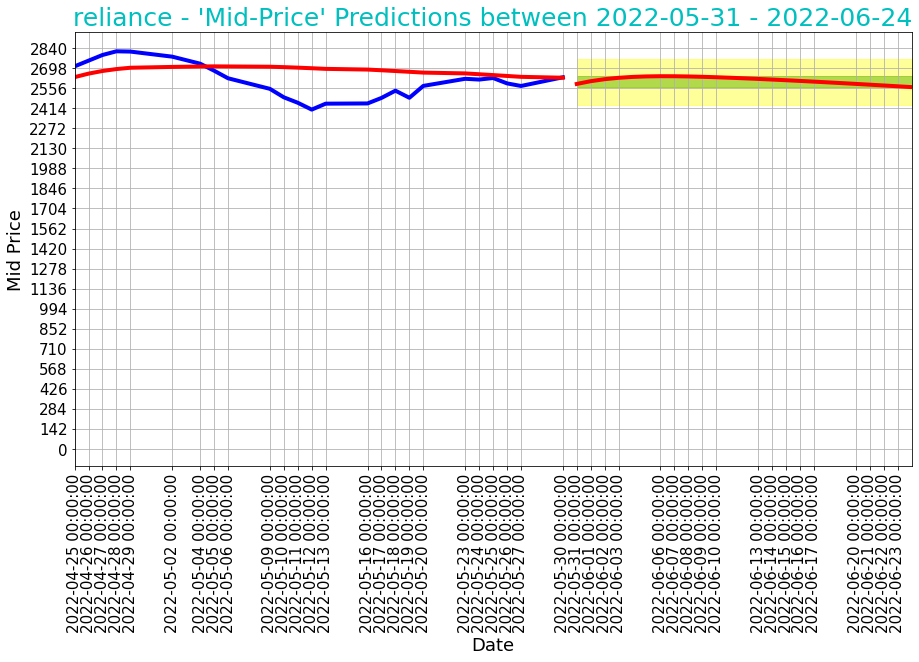

In [76]:
# Zoom In future Prediction
plt.close()

best_epoch = get_best_epoch()
best_mse = float(result_train_and_predictions[best_epoch]["MSE"])

plt.figure(figsize=(15, 8))
# plt.plot(range(df.shape[0]),all_mid_data,color='b')
plt.plot(
    [index_to_date_map(i) for i in range(df.shape[0])],
    get_unscaled_data(all_mid_data),
    color="b",
)
for xval, yval in zip(
    result_train_and_predictions["x_axis_seq"],
    result_train_and_predictions[best_epoch]["predictions_over_time"],
):
    plt.plot([index_to_date_map(i) for i in xval], get_unscaled_data(yval), color="r")

plt.title(
    "{} - 'Mid-Price' Predictions between {} - {}".format(
        stock_name,
        index_to_date_map(xval[0]).date(),
        index_to_date_map(xval[-1]).date(),
    ),
    fontsize=25,
    color="c",
)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Mid Price", fontsize=18)
plt.yticks(
    [i for i in range(0, max_range_on_yaxis, hop_size_on_yaxis)],
    [i for i in range(0, max_range_on_yaxis, hop_size_on_yaxis)],
)
plt.xticks(
    [
        index_to_date_map(i)
        for i in range(train_end_index - 600, xval[-1], 1)
        if index_to_date_map(i).weekday() < 5
    ],
    [
        index_to_date_map(i)
        for i in range(train_end_index - 600, xval[-1], 1)
        if index_to_date_map(i).weekday() < 5
    ],
    rotation=90,
)


# plt.axvspan(index_to_date_map(result_train_and_predictions["x_axis_seq"][-1][0]), index_to_date_map(result_train_and_predictions["x_axis_seq"][-1][-1]), ymin=min(yval), ymax=max(yval), alpha=0.5, color='g')

mse_to_prcnt = math.sqrt(best_mse)
mse_to_prcnt = np.array(mse_to_prcnt)
bound_error = get_unscaled_data(mse_to_prcnt)
# variation withing the 20 days predicted
plt.fill_between(
    [index_to_date_map(i) for i in xval],
    max(get_unscaled_data(yval)),
    min(get_unscaled_data(yval)),
    alpha=0.5,
    color="g",
)

# Probable bounded error based on MSE
plt.fill_between(
    [index_to_date_map(i) for i in xval],
    max(get_unscaled_data(yval)) + bound_error,
    min(get_unscaled_data(yval)) - bound_error,
    alpha=0.4,
    color="yellow",
)


# plt.xticks([index_to_date_map(i) for i in range(train_end_index-500,test_end_index,10)], [index_to_date_map(i).date() for i in range(train_end_index-500,test_end_index,10)], rotation=90)
# plt.xlim(index_to_date_map(train_end_index-10),index_to_date_map(test_end_index-1))
plt.xlim(
    index_to_date_map(result_train_and_predictions["x_axis_seq"][-2][0]),
    index_to_date_map(result_train_and_predictions["x_axis_seq"][-1][-1]),
)
plt.grid()
plt.show()

                                        ------------------- Export Best Result to JSON for API --------------

In [77]:
# Export Best Result to JSON for API
def generate_export(epoch_no):
    best_mse = float(result_train_and_predictions[epoch_no]["MSE"])
    mse_to_prcnt = math.sqrt(best_mse)
    mse_to_prcnt = np.array(mse_to_prcnt)
    bound_error = get_unscaled_data(mse_to_prcnt)
    transporter = {}
    transporter["stock_name"] = stock_name
    transporter["future_prediction_start"] = str(
        index_to_date_map(result_train_and_predictions["x_axis_seq"][-1][0]).date()
    )
    transporter["future_prediction_end"] = str(
        index_to_date_map(result_train_and_predictions["x_axis_seq"][-1][-1]).date()
    )
    transporter["bounded_error_upper"] = round(
        float(
            max(
                get_unscaled_data(
                    result_train_and_predictions[epoch_no]["predictions_over_time"][-1]
                )
            )
            + bound_error
        ),
        3,
    )
    transporter["bounded_error_lower"] = round(
        float(
            min(
                get_unscaled_data(
                    result_train_and_predictions[epoch_no]["predictions_over_time"][-1]
                )
            )
            - bound_error
        ),
        3,
    )
    transporter["original_data"] = {}
    transporter["original_data"]["date"] = [
        str(index_to_date_map(i).date()) for i in range(df.shape[0])
    ]
    transporter["original_data"]["price"] = get_unscaled_data(all_mid_data)
    predict_test_date = []
    predict_test_data = []
    for xval, yval in zip(
        result_train_and_predictions["x_axis_seq"],
        result_train_and_predictions[str(epoch_no)]["predictions_over_time"],
    ):
        predict_test_date.extend([str(index_to_date_map(i).date()) for i in xval])
        predict_test_data.extend(get_unscaled_data(yval))
    transporter["validation_and_future_prediction"] = {}
    transporter["validation_and_future_prediction"]["date"] = predict_test_date
    transporter["validation_and_future_prediction"]["price"] = predict_test_data
    with open(dir_export + "/api_" + stock_name + ".json", "w") as fp:
        json.dump(transporter, fp, indent=4)


generate_export(get_best_epoch())

In [ ]:
# Structure for JSON API export
"""
{
    "stock_name": "RELIANCE",
    "future_prediction_start": "2022-05-31",
    "future_prediction_end": "2022-06-24",
    "bounded_error_upper": 2728.525,
    "bounded_error_lower": 2372.984,
    "original_data": {
        "date": [
            "1995-07-10",
            "2022-05-30"
        ],
        "price": [
            15.65,
            2626.925
        ]
    },
    "validation_and_future_prediction": {
        "date": [
            "2020-05-29",
            "2022-06-24"
        ],
        "price": [
            1355.472,
            2500.506
        ]
    }
}
"""

                                                --------------- Let's Skip To The Good Part -----------------
<img src="https://drive.google.com/uc?id=1X-IrJ0gKQVKbDdffTozjNUnwOSTr_VNF" 
        alt="Let's Skip To The Good Part.jpeg" 
        width="8400" 
        height="600"
        style="display: block; margin: 0 auto" />

In [79]:
TRADE = ["api_britannia.json", "api_reliance.json", "api_sbin.json", "api_itc.json",]
TRADE_DELTA = {
    "api_britannia.json": 20,
    "api_itc.json": 20,
    "api_reliance.json": 10,
    "api_sbin.json": 15,
}
trade_stock = TRADE[stock_of_interest_index]

f = open(dir_export + "/" + trade_stock)
data = json.load(f)
stock_name = data["stock_name"]

investment_end = data["original_data"]["date"][-1]
investment_start = data["validation_and_future_prediction"]["date"][0]

index_upper_limit_for_original = data["original_data"]["date"].index(investment_start)
index_lower_limit_for_prediction = data["validation_and_future_prediction"][
    "date"
].index(investment_end)

index_tracker_original = 0
index_tracker_prediction = 0

#print(index_lower_limit_for_prediction, index_upper_limit_for_original)

date = data["original_data"]["date"][index_upper_limit_for_original:]
original_price = data["original_data"]["price"][index_upper_limit_for_original:]

predicted_price = data["validation_and_future_prediction"]["price"][
    : index_lower_limit_for_prediction + 1
]

#print(len(predicted_price), len(date), len(original_price))

trade_file_name = dir_trade + "/trade_" + stock_name.lower() + ".csv"

with open(trade_file_name, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Date", "Real", "Predicted"])
    writer.writerows(zip(date, original_price, predicted_price))

r = pd.read_csv(trade_file_name)

In [80]:
initial_valuation = 100000
delta = TRADE_DELTA[trade_stock]
stoploss = 0.01


profit_count = 0
loss_count = 0
current_valuation = initial_valuation
trade_info = "{:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}"
print(
    trade_info.format(
        "#",
        "Date",
        "Stock Price",
        "Real %",
        "Predicted %",
        "Call",
        "P&L",
        "Valuation",
        "Start Date",
    ),
    end="\n\n",
)
print(
    trade_info.format(
        "0",
        r.iloc[0]["Date"],
        "₹ {:,.2f}".format(round(r.iloc[0]["Real"])),
        "{:} %".format("--"),
        "{:} %".format("--"),
        "--",
        "₹ {:}".format("--"),
        "₹ {:}".format("--"),
        "NA",
    )
)

# Graph data
grapher_date = [r.iloc[0]["Date"]]
grapher_stock_change_percentage = [0]
grapher_investment_change_percentage = [0]
counter = 1
for i in range(20, len(predicted_price), delta):
    trade_initation_date = r.iloc[i - delta]["Date"]
    trade_completion_date = r.iloc[i]["Date"]
    real_change = (r.iloc[i]["Real"] - r.iloc[i - delta]["Real"]) / r.iloc[i - delta][
        "Real"
    ]
    predicted_change = (
        r.iloc[i]["Predicted"] - r.iloc[i - delta]["Predicted"]
    ) / r.iloc[i - delta]["Predicted"]

    nature = ""
    alpha = 0
    current_pnl = 0
    if predicted_change > 0.003 or predicted_change < -0.003:
        # Take trade
        nature = "BUY" if predicted_change > 0 else "SELL"

        if (real_change < 0 and predicted_change < 0) or (
            real_change > 0 and predicted_change > 0
        ):
            # Real price went as predicted
            alpha = 1
            profit_count += 1
        else:
            # Real price went opposite
            alpha = -1
            loss_count += 1
        current_pnl = (
            current_valuation * abs(real_change)
            if alpha > 0
            else current_valuation * abs(stoploss) * -1
        )
        current_valuation += current_pnl
    else:
        nature = "NOP"

    print(
        trade_info.format(
            counter,
            trade_completion_date,
            "₹ {:,.2f}".format(round(r.iloc[i]["Real"])),
            "{:+} %".format(round(real_change, 4)),
            "{:+} %".format(round(predicted_change, 4)),
            nature,
            "₹ {:+,.2f}".format(round(current_pnl, 3)),
            "₹ {:+,.2f}".format(round(current_valuation, 3)),
            trade_initation_date,
        )
    )

    counter += 1

    # Graph data
    real_percent_change_since_start_of_trade = (
        (r.iloc[i]["Real"] - r.iloc[0]["Real"]) / r.iloc[0]["Real"]
    ) * 100
    investment_percent_change_since_start_of_trade = (
        (current_valuation - initial_valuation) / initial_valuation
    ) * 100
    grapher_date.append(trade_completion_date)
    grapher_stock_change_percentage.append(
        round(real_percent_change_since_start_of_trade, 4)
    )
    grapher_investment_change_percentage.append(
        round(investment_percent_change_since_start_of_trade, 4)
    )

change_in_investment = "{:+}%".format(
    round((((current_valuation - initial_valuation) / initial_valuation) * 100), 3)
)
change_in_stock = "{:+}%".format(
    round(((r.iloc[i]["Real"] - r.iloc[0]["Real"]) / r.iloc[0]["Real"]) * 100, 3)
)

print("\n\n")
print("{:<20} {:<15}".format("Change in Investment: ", change_in_investment))
print("{:<20} {:<15}".format("Change in Stock Price: ", change_in_stock))
print("\n")
print("{:<20} {:<15}".format("# Profit: ", profit_count))
print("{:<20} {:<15}".format("# Loss: ", loss_count))

#     Date            Stock Price     Real %          Predicted %     Call            P&L             Valuation       Start Date     

0     2020-05-29      ₹ 1,462.00      -- %            -- %            --              ₹ --            ₹ --            NA             
1     2020-06-26      ₹ 1,734.00      +0.1233 %       +0.001 %        NOP             ₹ +0.00         ₹ +100,000.00   2020-06-12     
2     2020-07-10      ₹ 1,854.00      +0.0693 %       +0.1949 %       BUY             ₹ +6,927.67     ₹ +106,927.67   2020-06-26     
3     2020-07-24      ₹ 2,109.00      +0.1374 %       +0.0094 %       BUY             ₹ +14,694.27    ₹ +121,621.93   2020-07-10     
4     2020-08-07      ₹ 2,139.00      +0.0138 %       +0.1483 %       BUY             ₹ +1,683.63     ₹ +123,305.56   2020-07-24     
5     2020-08-21      ₹ 2,098.00      -0.0188 %       +0.0568 %       BUY             ₹ -1,233.06     ₹ +122,072.51   2020-08-07     
6     2020-09-04      ₹ 2,081.00      -0.0082 %       -0.0075

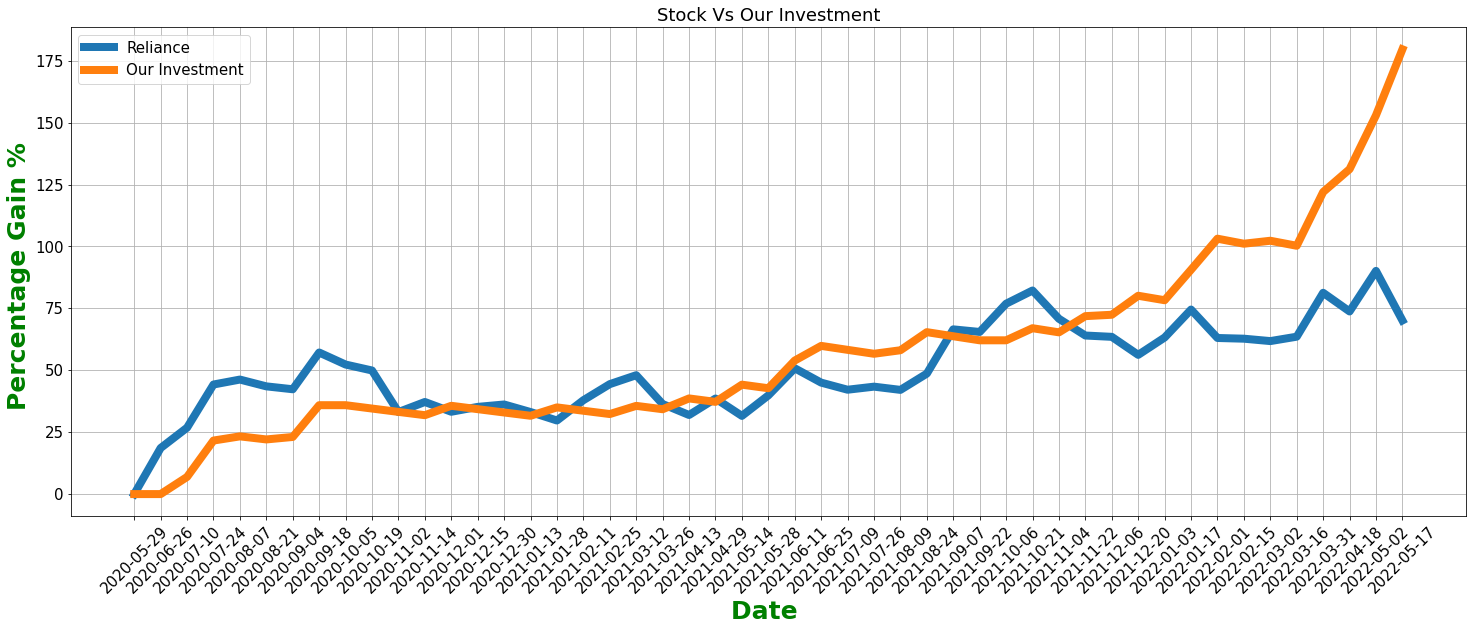

In [81]:
plt.figure(figsize=(25, 9))
plt.rcParams.update({"font.size": 15})
plt.rcParams.update({"lines.linewidth": 8})

plt.title("Stock Vs Our Investment")
plt.xlabel("Date ", fontweight="bold", fontsize=25, color="g")
plt.ylabel("Percentage Gain % ", fontweight="bold", fontsize=25, color="g")

plt.plot(grapher_date, grapher_stock_change_percentage, label=stock_name.capitalize())
plt.plot(grapher_date, grapher_investment_change_percentage, label="Our Investment")
plt.xticks(
    grapher_date,
    rotation=45,
)

plt.legend()
plt.grid()
plt.show()

                                                --------------- END OF PROJECT -----------------
                                                            Below is house-keeping codes

                                    ------------- Export All results of train and predict as image graph -----------

In [ ]:
# Export All results of train and predict as image graph
def save_graph(epoche_no, color, comment):
    plt.figure(figsize=(30, 10))
    plt.plot(
        [index_to_date_map(i) for i in range(df.shape[0])],
        get_unscaled_data(all_mid_data),
        color="b",
    )
    """
    color = "g"
    if epoche_no > 6:
        plt.text(
            index_to_date_map(train_end_index - 100),
            0.15,
            "OVERFITTING!! Bad Network :(",
            fontsize=40,
            color="r",
            rotation=45,
        )
        color = "r"
    if epoche_no < 3:
        plt.text(
            index_to_date_map(train_end_index),
            0.5,
            "UNDERFITTING",
            fontsize=40,
            color="r",
            rotation=45,
        )
        color = "r"
    """
    plt.text(
        index_to_date_map(train_end_index - 50),
        2 * hop_size_on_yaxis,
        comment,
        fontsize=40,
        color=color,
        rotation=45,
    )
    count = 1
    plt.grid()
    for xval, yval in zip(
        result_train_and_predictions["x_axis_seq"],
        result_train_and_predictions[str(epoche_no)]["predictions_over_time"],
    ):
        plt.plot(
            [index_to_date_map(i) for i in xval], get_unscaled_data(yval), color=color
        )

        plt.title(
            "{} - Stock Movement Predictions Over Epoch-{}.{}".format(
                stock_name, epoche_no - 1, count
            ),
            fontsize=25,
            color="c",
        )
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Mid Price", fontsize=18)
        plt.yticks(
            [i for i in range(0, max_range_on_yaxis, hop_size_on_yaxis)],
            [i for i in range(0, max_range_on_yaxis, hop_size_on_yaxis)],
        )
        # plt.xticks([index_to_date_map(i) for i in range(train_end_index - 600, xval[-1], 15)], [index_to_date_map(i).date() for i in range(train_end_index - 600, xval[-1], 15)], rotation=90)
        plt.xticks(
            [
                index_to_date_map(i)
                for i in range(
                    train_end_index - 600,
                    result_train_and_predictions["x_axis_seq"][-1][-1],
                    15,
                )
            ],
            [
                index_to_date_map(i).date()
                for i in range(
                    train_end_index - 600,
                    result_train_and_predictions["x_axis_seq"][-1][-1],
                    15,
                )
            ],
            rotation=90,
        )
        # plt.xlim(index_to_date_map(train_end_index - 600), index_to_date_map(xval[-1]))
        plt.xlim(
            index_to_date_map(train_end_index - 600),
            index_to_date_map(result_train_and_predictions["x_axis_seq"][-1][-1]),
        )
        plt.savefig(
            dir_learning_images
            + "/{}/{}-{}.{}.png".format(stock_name, stock_name, epoche_no - 1, count),
            bbox_inches="tight",
        )
        count += 1


mse = []
for key, value in result_train_and_predictions.items():
    if key == "x_axis_seq":
        continue
    mse.append(value["MSE"])
mse = sorted(mse)
mse = mse[:10]

for i in range(len(mse)):
    for key, value in result_train_and_predictions.items():
        if key == "x_axis_seq":
            continue
        if value["MSE"] == mse[i]:
            plt.close()
            color = "r" if i > 4 else "g"
            comment = "Bad Network :(" if i > 4 else "Doing Good!"
            if i == 0:
                comment = "Best Result! :)"
            save_graph(int(key), color, comment)

In [ ]:
# Prepare files for transportation
! zip -r transport.zip *

In [ ]:
# Prepare the unload
! unzip transport.zip > /dev/null

In [ ]:
# Clear deck
! rm -rf data export learning_images neural_compute

In [ ]:
! rm -rf __MACOSX



```
# Code Formatting
```



In [ ]:
from google.colab import drive

drive.mount("/content/drive")
!pip install black[jupyter] --quiet
!black "/content/drive/MyDrive/Colab Notebooks/Stock_Prediction_LSTM.ipynb"
drive.flush_and_unmount()

In [ ]:
# old csv api export
def csv_for_api(epoche_no):
    best_prediction_epoch = epoche_no

    result_all_date = [index_to_date_map(i).date() for i in range(df.shape[0])]
    result_all_data = get_unscaled_data(all_mid_data)

    predict_test_date = []
    predict_test_data = []
    for xval, yval in zip(
        result_train_and_predictions["x_axis_seq"],
        result_train_and_predictions[str(best_prediction_epoch)][
            "predictions_over_time"
        ],
    ):
        predict_test_date.extend([str(index_to_date_map(i).date()) for i in xval])
        predict_test_data.extend(get_unscaled_data(yval))

    with open("api_original_data.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(zip(result_all_date, result_all_data))

    with open("api_validation_and_future_prediction.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(zip(predict_test_date, predict_test_data))


csv_for_api(get_best_epoch())